# Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# WandB Init

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
!wandb login

In [ ]:
wandb.init(project="Malaria-Detection", entity="neuralearn")

#wandb.tensorboard.patch(root_logdir="./logs")
#wandb.init(project="Malaria-Detection", entity="neuralearn", sync_tensorboard=True)

In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 5,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

# Data Loading & Splitting

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'] )

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))

  val_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))

  return train_dataset, val_dataset, train_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [ ]:
for data in train_dataset.take(2):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

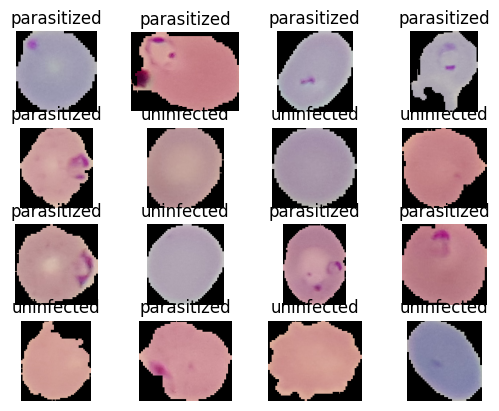

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(1)

'uninfected'

# Data Augmentation

In [ ]:
IM_SIZE = 224

## tf.image

In [ ]:
@tf.function
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [ ]:
@tf.function
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

  return image, label

TF Layers

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(IM_SIZE, IM_SIZE),
       Rescaling(1./255),
])

In [ ]:
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',),
       #RandomContrast(factor=0.1),
])


# To use with map()
@tf.function
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [ ]:
original_image, label = next(iter(train_dataset))

In [ ]:
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor = 0.3)

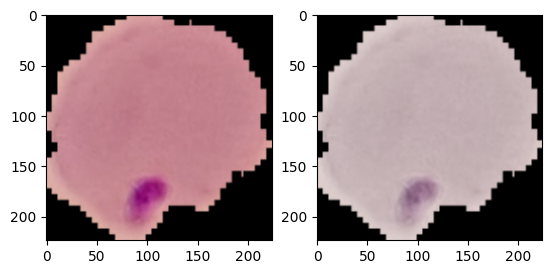

In [ ]:
visualize(original_image[0], augmented_image[0])

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    #RandomContrast(factor=0.1),
  ]
)

## Custom Layer

In [ ]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

  @tf.function
  def call(self, image):
    return tf.image.rot90(image)

# Data Loading

## Loading

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .map(resize_rescale)
    # .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 8)
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

In [ ]:
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)

## Mixup Data Aug

Not Good for this dataset

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 4096, reshuffle_each_iteration = True)
    .map(mixup, num_parallel_calls = tf.data.AUTOTUNE)
    #map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

## Cutmix Data Aug

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Albumentations

In [ ]:
transforms = A.Compose(
    [
      A.Resize(IM_SIZE, IM_SIZE),
      A.OneOf([A.HorizontalFlip(),
                A.VerticalFlip(),], p = 0.3),
      A.RandomRotate90(),
      #A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
      #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
      A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])

In [ ]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image

In [ ]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [ ]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

In [ ]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

In [ ]:
plt.figure(figsize=(15,15))

for i in range(1,32):
  plt.subplot(8,4,i)
  plt.imshow(im[i])

## Repeating the Dataset

In [ ]:
def augment_1(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.random_brightness(image, 0.2)
  return image, label

In [ ]:
def augment_2(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.random_flip_up_down(image)
  return image, label

In [ ]:
def augment_3(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.flip_left_right(image)
  return image, label

In [ ]:
def augment_4(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  return image, label

In [ ]:
def augment_5(image, label):
  image, label = resize_rescale(image, label)

  return image, label

In [ ]:
train_dataset_1 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_1)
)

In [ ]:
train_dataset_2 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_2)
)

In [ ]:
train_dataset_3 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_3)
)

In [ ]:
train_dataset_4 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_4)
)

In [ ]:
train_dataset_5 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_5)
)

In [ ]:
full_dataset = train_dataset_1.concatenate(train_dataset_2).concatenate(train_dataset_3).concatenate(train_dataset_4).concatenate(train_dataset_5)

In [ ]:
full_dataset = (
    full_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
full_dataset

# WandB Data Versioning

## Data Loading

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

print(dataset)

In [ ]:
k = 0
for data in dataset[0]:

  with open('dataset/malaria_dataset_'+str(k) + '.npz', mode = 'wb') as file:
      np.savez(file, data)
  k += 1
  if(k%1000 == 0):
    print(k)

In [ ]:
def load_original_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    original_data = wandb.Artifact(
        name = "new_dataset",
        type="raw_data",
        description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
        metadata = {"source": "TFDS",
                    "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                    "source_code": "tfds.image_classification.Malaria",
                    "version": "1.0.0",
                    "download_size": "337.08 MiB",
                    }
    )

    original_data.add_dir('dataset/')

    run.log_artifact(original_data)

In [ ]:
load_original_data()

## Data Preprocessing

In [ ]:
with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
  artifact = run.use_artifact('neuralearn/Malaria-Detection/new_dataset:v1', type='raw_data')
  artifact_dir = artifact.download()

In [ ]:
IM_SIZE = 224
def resize_rescale(image):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

In [ ]:
def preprocess_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/new_dataset:v1', type='raw_data')
    artifact_dir = artifact.download()

    preprocessed_data = wandb.Artifact(
        name = "preprocessed_dataset",
        type="preprocessed_data",
        description = "A Preprocessed version of the Malaria dataset",
    )

    artifact_directory = "artifacts/new_dataset:v1/"

    dataset_x = []
    dataset_y = []

    for f in os.listdir(artifact_directory)[:1000]:
      with open(artifact_directory + f, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        x,y = npz_array.f.arr_0

        dataset_x.append(resize_rescale(x))
        dataset_y.append(y)

    #dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

    with preprocessed_data.new_file("prep_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(preprocessed_data)

In [ ]:
preprocess_data()

## Splitting

In [ ]:
run = wandb.init()
artifact = run.use_artifact('neuralearn/Malaria-Detection/preprocessed_dataset:v2', type='preprocessed_data')
artifact_dir = artifact.download()

In [ ]:
def split_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/preprocessed_dataset:v2', type='preprocessed_data')
    artifact_dir = artifact.download()

    train_data = wandb.Artifact(
        name = "train_dataset",
        type="preprocessed_data",
        description = "Training dataset",

    )
    val_data = wandb.Artifact(

        name = "val_dataset",
        type="preprocessed_data",
        description = "Validation dataset",

        )
    test_data = wandb.Artifact(
        name = "test_dataset",
        type="preprocessed_data",
        description = "Test dataset",

        )

    artifact_file = "artifacts/preprocessed_dataset:v2/prep_dataset.npz"

    with open(artifact_file, 'rb') as file:
      npz_arr = np.load(file, allow_pickle = True)
      arr = npz_arr.f.arr_0

    train_split = 0.8
    val_split = 0.1
    test_split = 0.1

    data_len = len(arr[0])

    train_arr = [arr[0][0:int(train_split*data_len)], arr[1][0:int(train_split*data_len)]]
    val_arr = [arr[0][int(train_split*data_len):int((train_split+val_split)*data_len)], arr[1][int(train_split*data_len):int((train_split+val_split)*data_len)] ]
    test_arr = [arr[0][int((train_split+val_split)*data_len):], arr[1][int((train_split+val_split)*data_len):] ]


    with train_data.new_file("train_dataset.npz", mode = "wb") as file:
        np.savez(file, train_arr)

    with val_data.new_file("val_dataset.npz", mode = "wb") as file:
        np.savez(file, val_arr)

    with test_data.new_file("test_dataset.npz", mode = "wb") as file:
        np.savez(file, test_arr)


    run.log_artifact(train_data)
    run.log_artifact(val_data)
    run.log_artifact(test_data)

In [ ]:
split_data()

## Augmentation

In [ ]:
### tf.image augment
def augment(image):
  image = tf.image.rot90(image)
  image = tf.image.flip_left_right(image)

  return image

In [ ]:
def augment_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    augmented_data = wandb.Artifact(
        name = "Augmented_dataset",
        type="preprocessed_data",
        description = "An Augmented version of the Malaria train dataset",
    )

    artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"

    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]

    with augmented_data.new_file("aug_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(augmented_data)

In [ ]:
augment_data()

# Model Building

## Wandb Model Versioning

### Untrained Model Versioning

In [ ]:
def log_model():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:


    untrained_model = wandb.Artifact(
        name = "Untrained_model",
        type="model",
        description = "The initial version of our lenet model",
        metadata = CONFIGURATION
    )
    filename = 'lenet.h5'
    lenet_model.save(filename)

    untrained_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(untrained_model)

In [ ]:
log_model()

### Trained Model versioning

In [ ]:
def train_and_log():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/Augmented_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    trained_sequential_model = wandb.Artifact(
        name = "Trained_Sequential_model",
        type="model",
        description = "A trained version of our model",
        metadata = CONFIGURATION,
    )

    artifact_file = "artifacts/Augmented_dataset:v0/aug_dataset.npz"

    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(im)
        dataset_y = arr[1]


    d_x = tf.convert_to_tensor(dataset_x, dtype = tf.float32)
    d_y = tf.convert_to_tensor(dataset_y, dtype = tf.float32)

    d = tf.data.Dataset.from_tensor_slices((d_x,d_y))

    train_d = (
        d
        .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )


    artifact = run.use_artifact('neuralearn/Malaria-Detection/Untrained_model:v0', type='model')
    artifact_dir = artifact.download()

    artifact_file = "artifacts/Untrained_model:v0/lenet.h5"

    lenet_model = tf.keras.models.load_model(artifact_file)

    metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
          loss = BinaryCrossentropy(),
          metrics = metrics)

    lenet_model.fit(
        train_d,
        epochs = 3,
        verbose = 1,
        callbacks=[WandbCallback()],
    )

    filename = 'lenet_trained.h5'
    lenet_model.save(filename)

    trained_sequential_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(trained_sequential_model)

In [ ]:
train_and_log()

## WandB

In [ ]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

## Sequential

In [ ]:
dropout_rate = 0.2
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
    #resize_rescale_layers,
    data_augmentation,
    Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate),
    Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation='relu', kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (Batch  (None, 220, 220, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Bat  (None, 106, 106, 16)     

## Functional

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides= 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides= 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),



])
feature_extractor_seq_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

## Mixing Seq and Functional

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_8 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                       

## Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_16 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_17 (Ba  multiple                  

## Custom Subclass

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)

  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)

    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output

In [ ]:
IM_SIZE = 224
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Flatten(),

                             NeuralearnDense(100, activation = "relu"),
                             BatchNormalization(),

                             NeuralearnDense(10, activation = "relu"),
                             BatchNormalization(),

                             NeuralearnDense(1, activation = "sigmoid"),

])
lenet_custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

# Callbacks

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [ ]:
test_dataset = test_dataset.batch(1)

# images = wandb.Image(image_array, caption="Top: Output, Bottom: Input")

# wandb.log({"examples": images})

## Tensorboard

In [ ]:
class LogImagesCallbackTensorBoard(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    threshold = 0.5

    cm = confusion_matrix(labels, predicted > threshold)

    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image = tf.image.decode_png(buffer.getvalue(), channels=3)
    image = tf.expand_dims(image, axis = 0)

    CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
    IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
    image_writer = tf.summary.create_file_writer(IMAGE_DIR)

    with image_writer.as_default():
      tf.summary.image("Training data", image, step = epoch)

## WandB

In [ ]:
class LogImagesCallbackWandBPlot(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    print("labels", labels, labels.dtype)
    print("predicted", predicted, predicted.dtype)

    pred = []

    for i in range(len(predicted)):
      if(predicted[i][0] < 0.5):
        pred.append([1,0])
      else:
        pred.append([0,1])

    pred = np.array(pred)

    # wandb.log({"Confusion Matrix" : wandb.plot.confusion_matrix(
    #     probs = pred,
    #     y_true=labels,
    #     class_names=["Parasitized", "Uninfected"])})

    wandb.log({"ROC Curve" : wandb.plot.roc_curve(
        y_true = labels,
        y_probas = pred,
        labels = ['Parasitized', 'Uninfected'],
    )})

    wandb.log({'loss':logs['loss']})

In [ ]:
class LogImagesCallbackWandB(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    threshold = 0.5

    cm = confusion_matrix(labels, predicted > threshold)

    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image_array = tf.image.decode_png(buffer.getvalue(), channels=3)

    images = wandb.Image(image_array, caption="Confusion Matrix for epoch: {}".format(epoch))

    wandb.log(
        {"Confusion Matrix": images})


## Tensorflow

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [ ]:
def scheduler(epoch, lr):

  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()

  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_precision', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

In [ ]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

In [ ]:
! pip install -U tensorboard_plugin_profile

In [ ]:
! rm -rf ./logs/

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [ ]:
LOG_DIR = './logs/'+ CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq = 1, profile_batch = '100,132')

# Custom Metric and Loss

## Metrics

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name = 'Custom_Accuracy', FACTOR = 1):
    super(CustomAccuracy, self).__init__()
    self.FACTOR = FACTOR
    self.accuracy = self.add_weight(name = name, initializer = 'zeros')


  def update_state(self, y_true, y_pred, sample_weight = None):
    output = binary_accuracy(tf.cast(y_true, dtype = tf.float32), y_pred)*self.FACTOR
    self.accuracy.assign(tf.math.count_nonzero(output, dtype = tf.float32)/tf.cast(len(output), dtype = tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)

In [ ]:
def custom_accuracy(y_true, y_pred):
  print(binary_accuracy(y_true, y_pred))
  return binary_accuracy(y_true, y_pred)

In [ ]:
def custom_accuracy(FACTOR):
  def metric(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)* FACTOR
  return metric

## Loss

In [ ]:
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self, FACTOR):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR
  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* self.FACTOR

In [ ]:
def custom_bce(FACTOR):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* FACTOR
  return loss

In [ ]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

# Training

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.1),
              loss = BinaryCrossentropy(),
              metrics=metrics)

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 2, verbose = 1, callbacks=[scheduler_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/2
689/689 [==============================] - 86s 110ms/step - loss: 25.6849 - tp: 6453.0000 - fp: 4981.0000 - tn: 6040.0000 - fn: 4572.0000 - accuracy: 0.5667 - precision: 0.5644 - recall: 0.5853 - auc: 0.5926 - val_loss: 17.7054 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 11023.0000 - val_fn: 11023.0000 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/2
689/689 [==============================] - 55s 80ms/step - loss: 10.9372 - tp: 6057.0000 - fp: 4670.0000 - tn: 6352.0000 - fn: 4967.0000 - accuracy: 0.5629 - precision: 0.5646 - recall: 0.5494 - auc: 0.5900 - val_loss: 37.5034 - val_tp: 11022.0000 - val_fp: 11024.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.6250 - lr: 0.

In [ ]:
history = lenet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 23,#CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    #callbacks=[LogImagesCallbackWandB()]
    )

In [ ]:
wandb.finish()

# Hyper Param Tuning with WandB

In [ ]:
sweep_config = {
  "name" : "Malaria-Prediction-Sweep",
  "method" : "random",
  "metric": {
      "name" : "accuracy",
      "goal" : "maximize",
  },
  "parameters" : {

    "IM_SIZE": {
        "value" : 224,
    },

    "N_EPOCHS": {
        "value" : 1,
    },

    "KERNEL_SIZE": {
        "value" : 3,
    },

    "N_STRIDES": {
        "value" : 1,
    },

    "POOL_SIZE": {
        "value" : 224,
    },

    "N_FILTERS" : {
        "value" : 6,
    },

    "N_DENSE_1" : {
      "values" : [16, 32, 64, 128]
    },

    "N_DENSE_2" : {
      "values" : [16, 32, 64, 128]
    },

    "DROPOUT_RATE":{
      "min": 0.1,
      "max": 0.4
    },

    "REGULARIZATION_RATE" :{
      "distribution": "uniform",
      "min": 0.001,
      "max": 0.1
    },

    "LEARNING_RATE" :{
      "distribution": "uniform",
      "min": 1e-4,
      "max": 1e-2
    }
  },
}

sweep_id = wandb.sweep(sweep_config)

In [ ]:
IM_SIZE = 224
def model_tune(config):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu',kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= config['N_STRIDES']*2),
    Dropout(rate = config['DROPOUT_RATE'] ),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= 2),

    Flatten(),

    Dense( config['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( config['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

  ])


  return lenet_model

In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 1,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [ ]:
def train():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
        config = wandb.config
        model = model_tune(config)
        model.compile(
              optimizer= Adam(
                  learning_rate = config['LEARNING_RATE']),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )
        model.fit(val_dataset, epochs=2, callbacks = [WandbCallback()])
        #wandb.log({"loss": loss, "epoch": epoch})

count = 5 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

# Hyper Parameter Tuning

In [ ]:
IM_SIZE = 224
def model_tune(hparams):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu',kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = hparams[HP_DROPOUT]),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),

    Dense( hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),

    Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
  ])

  lenet_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

  lenet_model.fit(val_dataset, epochs=1)
  _, accuracy = lenet_model.evaluate(val_dataset)
  return accuracy

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2,0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001,0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

#fixed range of values is very large

In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout_rate,
              HP_REGULARIZATION_RATE: regularization_rate,
              HP_LEARNING_RATE: learning_rate,

          }
          file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

          with file_writer.as_default():
              hp.hparams(hparams)
              accuracy = model_tune(hparams)
              tf.summary.scalar('accuracy', accuracy, step = 0)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
          run_number += 1

# Custom Training Loops

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = CONFIGURATION['N_EPOCHS']

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/val'

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
      y_pred = lenet_model(x_batch, training = True)
      loss = custom_bce(y_batch, y_pred)

  #wandb.log({'loss':loss.numpy()})
  partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
    y_pred_val = lenet_model(x_batch_val, training = False)
    loss_val = custom_bce(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    return loss_val

In [ ]:
def neuralearn(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}".format(epoch+1))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch)

    print("Training Loss", loss)
    print("The accuracy is: ", METRIC.result())

    with custom_train_writer.as_default():
      tf.summary.scalar('Training Loss', data = loss, step = epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Training Accuracy', data = METRIC.result(), step = epoch)

    METRIC.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val, y_batch_val)

    print("The Validation loss", loss_val)
    print("The Validation accuracy is: ", METRIC_VAL.result())

    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Loss', data = loss_val, step = epoch)
    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Accuracy', data = METRIC_VAL.result(), step = epoch)

    METRIC_VAL.reset_states()
  print("Training Complete!!!!")

# Visualizations

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir=logs

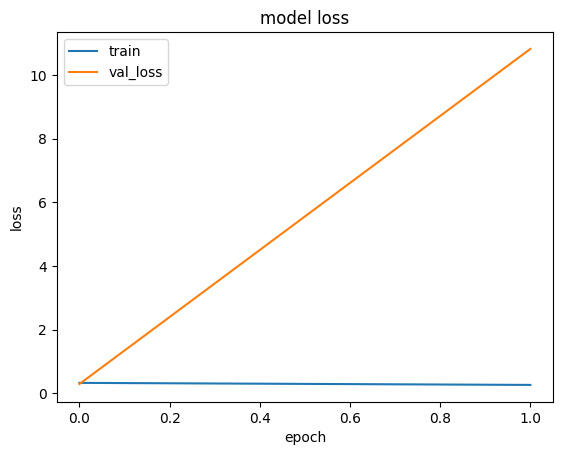

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

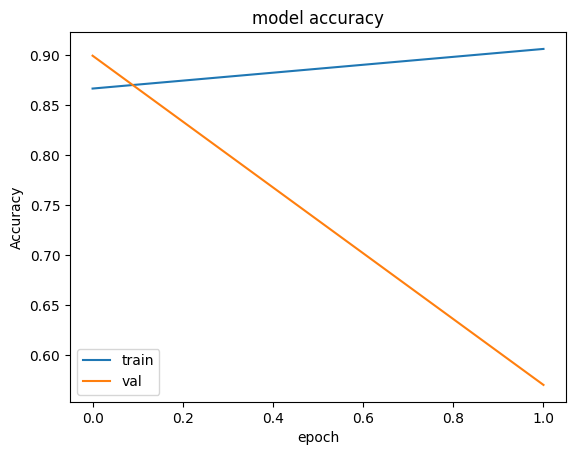

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
test_dataset = test_dataset.batch(1)
model.evaluate(test_dataset)

22046/22046 [==============================] - 115s 5ms/step - loss: 10.8241 - tp: 9982.0000 - fp: 8428.0000 - tn: 2594.0000 - fn: 1042.0000 - accuracy: 0.5704 - precision: 0.5422 - recall: 0.9055 - auc: 0.5860


[10.824084281921387,
 9982.0,
 8428.0,
 2594.0,
 1042.0,
 0.5704436302185059,
 0.5422053337097168,
 0.9054789543151855,
 0.5860189199447632]

In [ ]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 0s 206ms/step


1.0

In [ ]:
def infected(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 19ms/step


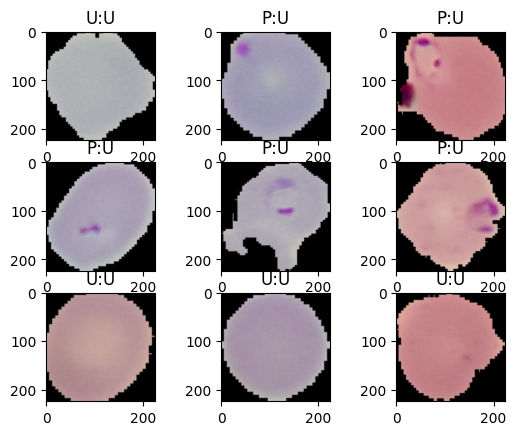

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(infected(label.numpy()[0]))+':'+str(infected(model.predict(image)[0][0])))

In [ ]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

NameError: name 'test_dataset' is not defined

In [ ]:
labels = np.array([i[0] for i in labels])
labels

NameError: name 'np' is not defined

In [ ]:
predicted = model.predict(np.array(inp)[:,0,...])
predicted[:,0]

NameError: name 'model' is not defined

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()